In [1]:
import time
from PIL import Image
import numpy as np

from keras import backend


Using TensorFlow backend.


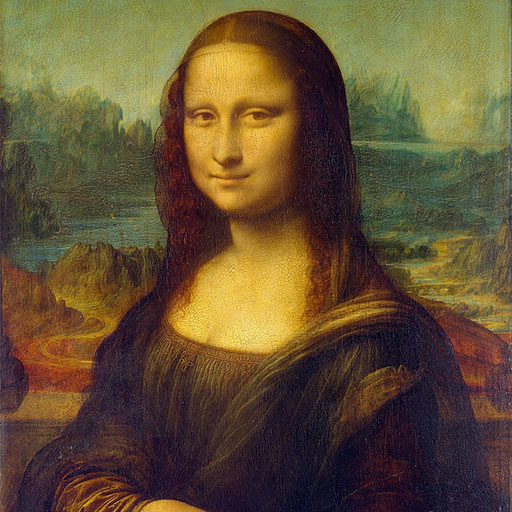

In [2]:
height = 512
width = 512

content_image_path = 'images/content.jpg'
content_image = Image.open(content_image_path)
content_image = content_image.resize((width, height))
content_image

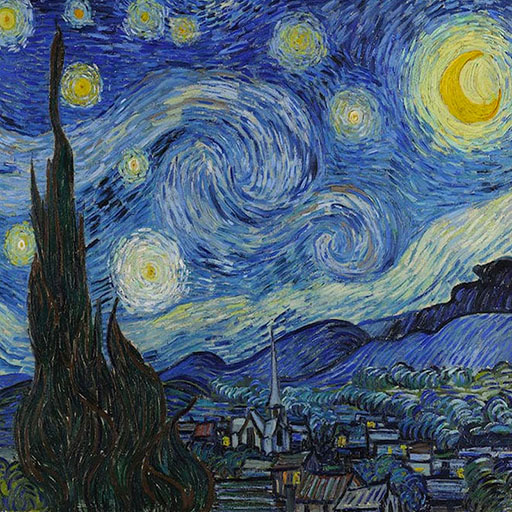

In [3]:
style_image_path = 'images/style.jpg'
style_image = Image.open(style_image_path)
style_image = style_image.resize((width, height))
style_image

In [4]:
content_array = np.asarray(content_image, dtype='float32')
content_array = np.expand_dims(content_array, axis=0)
print(content_array.shape)

style_array = np.asarray(style_image, dtype='float32')
style_array = np.expand_dims(style_array, axis=0)
print(style_array.shape)

(1, 512, 512, 3)
(1, 512, 512, 3)


In [5]:
content_array[:, :, :, 0] -= 103.939
content_array[:, :, :, 1] -= 116.779
content_array[:, :, :, 2] -= 123.68
content_array = content_array[:, :, :, ::-1]

style_array[:, :, :, 0] -= 103.939
style_array[:, :, :, 1] -= 116.779
style_array[:, :, :, 2] -= 123.68
style_array = style_array[:, :, :, ::-1]

In [6]:
content_image = backend.variable(content_array)
style_image = backend.variable(style_array)
combination_image = backend.placeholder((1, height, width, 3))

In [7]:
input_tensor = backend.concatenate([content_image,
                                    style_image,
                                    combination_image], axis=0)

# Leveraging the VGG16 Model

As we coded in the previous notebook, we will once again import the VGG architecture. However, this time we will only leverage the architecture and not need to load the weights. We will be creating our own loss chain to exploit VGG for Style Transfer.

In [8]:
from keras.models import Model
from keras.applications.vgg16 import VGG16

from scipy.optimize import fmin_l_bfgs_b
from scipy.misc import imsave

In [9]:
model = VGG16(input_tensor=input_tensor, weights='imagenet',
              include_top=False)

In [10]:
layers = dict([(layer.name, layer.output) for layer in model.layers])
layers

{'input_1': <tf.Tensor 'concat:0' shape=(3, 512, 512, 3) dtype=float32>,
 'block1_conv1': <tf.Tensor 'block1_conv1/Relu:0' shape=(3, 512, 512, 64) dtype=float32>,
 'block1_conv2': <tf.Tensor 'block1_conv2/Relu:0' shape=(3, 512, 512, 64) dtype=float32>,
 'block1_pool': <tf.Tensor 'block1_pool/MaxPool:0' shape=(3, 256, 256, 64) dtype=float32>,
 'block2_conv1': <tf.Tensor 'block2_conv1/Relu:0' shape=(3, 256, 256, 128) dtype=float32>,
 'block2_conv2': <tf.Tensor 'block2_conv2/Relu:0' shape=(3, 256, 256, 128) dtype=float32>,
 'block2_pool': <tf.Tensor 'block2_pool/MaxPool:0' shape=(3, 128, 128, 128) dtype=float32>,
 'block3_conv1': <tf.Tensor 'block3_conv1/Relu:0' shape=(3, 128, 128, 256) dtype=float32>,
 'block3_conv2': <tf.Tensor 'block3_conv2/Relu:0' shape=(3, 128, 128, 256) dtype=float32>,
 'block3_conv3': <tf.Tensor 'block3_conv3/Relu:0' shape=(3, 128, 128, 256) dtype=float32>,
 'block3_pool': <tf.Tensor 'block3_pool/MaxPool:0' shape=(3, 64, 64, 256) dtype=float32>,
 'block4_conv1': <t

# Creating the Content Loss

We will hand code the first loss function to be added to our loss chain by hand. Then we will use some pre-coded helper functions for the rest of the loss chain.

In [11]:
content_weight = 0.025
style_weight = 5.0
total_variation_weight = 1.0

In [12]:
loss_chain = backend.variable(0.)

In [13]:
def content_loss(content, combination):
    return backend.sum(backend.square(combination - content))

layer_features = layers['block2_conv2']
content_image_features = layer_features[0, :, :, :]
combination_features = layer_features[2, :, :, :]

loss_chain += content_weight * content_loss(content_image_features,
                                      combination_features)

# \* HELPER FUNCTIONS \*

We're going to put the helper functions directly in the notebook this time instead of hidding them away. You don't need to be able to understand the math right now, but opening the hood and just looking should now not be so terrifying. 

The original Style Transfer notebook used in DLFD broke with recent Keras updates, so this notebook is almost completely based on the fantastic tutorials and notebooks found here: https://harishnarayanan.org/writing/artistic-style-transfer/ and here: https://github.com/hnarayanan/artistic-style-transfer. Make sure to check them out!

**NOTE**: Run the cell below to load in the helper functions, then continue your in class code in the next empty cell...


In [14]:
def gram_matrix(x):
    features = backend.batch_flatten(backend.permute_dimensions(x, (2, 0, 1)))
    gram = backend.dot(features, backend.transpose(features))
    return gram

def style_loss(style, combination):
    S = gram_matrix(style)
    C = gram_matrix(combination)
    channels = 3
    size = height * width
    return backend.sum(backend.square(S - C)) / (4. * (channels ** 2) * (size ** 2))

def total_variation_loss(x):
    a = backend.square(x[:, :height-1, :width-1, :] - x[:, 1:, :width-1, :])
    b = backend.square(x[:, :height-1, :width-1, :] - x[:, :height-1, 1:, :])
    return backend.sum(backend.pow(a + b, 1.25))

def eval_loss_and_grads(x):
    x = x.reshape((1, height, width, 3))
    outs = f_outputs([x])
    loss_value = outs[0]
    grad_values = outs[1].flatten().astype('float64')
    return loss_value, grad_values

class Evaluator(object):

    def __init__(self):
        self.loss_value = None
        self.grads_values = None

    def loss(self, x):
        assert self.loss_value is None
        loss_value, grad_values = eval_loss_and_grads(x)
        self.loss_value = loss_value
        self.grad_values = grad_values
        return self.loss_value

    def grads(self, x):
        assert self.loss_value is not None
        grad_values = np.copy(self.grad_values)
        self.loss_value = None
        self.grad_values = None
        return grad_values


# *Continue Your Code Below...*

Now that we have our helper functions processed, let's continue adding to our loss_chain by adding the layers that will define our style loss.

In [15]:
feature_layers = ['block1_conv2', 'block2_conv2',
                  'block3_conv3', 'block4_conv3',
                  'block5_conv3']
for layer_name in feature_layers:
    layer_features = layers[layer_name]
    style_features = layer_features[1, :, :, :]
    combination_features = layer_features[2, :, :, :]
    sl = style_loss(style_features, combination_features)
    loss_chain += (style_weight / len(feature_layers)) * sl
    
    

and we finish off the loss_chain by adding a "noisy" loss helper to smooth out the results a bit...

In [16]:
loss_chain += total_variation_weight * total_variation_loss(combination_image)

Now that our loss_chain is completely defined, we can use it to define our gradients...

In [17]:
grads = backend.gradients(loss_chain, combination_image)

and wrap it all up into our final evaluator.

In [18]:
outputs = [loss_chain]
outputs += grads
f_outputs = backend.function([combination_image], outputs)

evaluator = Evaluator()

We are now ready to start the process off by creating a temporary "output" image made of random values, and then start running iterations to bring the loss down between the content image and the output (x) while also bringing down the loss between the style image the output (x).

In [19]:
x = np.random.uniform(0, 255, (1, height, width, 3)) - 128.

iterations = 10

for i in range(iterations):
    print('Start of iteration', i)
    start_time = time.time()
    x, min_val, info = fmin_l_bfgs_b(evaluator.loss, x.flatten(),
                                     fprime=evaluator.grads, maxfun=20)
    print('Current loss value:', min_val)
    end_time = time.time()
    print('Iteration %d completed in %ds' % (i, end_time - start_time))

Start of iteration 0
Current loss value: 58028564000.0
Iteration 0 completed in 23s
Start of iteration 1
Current loss value: 29386744000.0
Iteration 1 completed in 16s
Start of iteration 2
Current loss value: 21555216000.0
Iteration 2 completed in 17s
Start of iteration 3
Current loss value: 19410725000.0
Iteration 3 completed in 16s
Start of iteration 4
Current loss value: 18589925000.0
Iteration 4 completed in 17s
Start of iteration 5
Current loss value: 18104865000.0
Iteration 5 completed in 17s
Start of iteration 6
Current loss value: 17776638000.0
Iteration 6 completed in 17s
Start of iteration 7
Current loss value: 17567210000.0
Iteration 7 completed in 17s
Start of iteration 8
Current loss value: 17433358000.0
Iteration 8 completed in 17s
Start of iteration 9
Current loss value: 17334288000.0
Iteration 9 completed in 17s


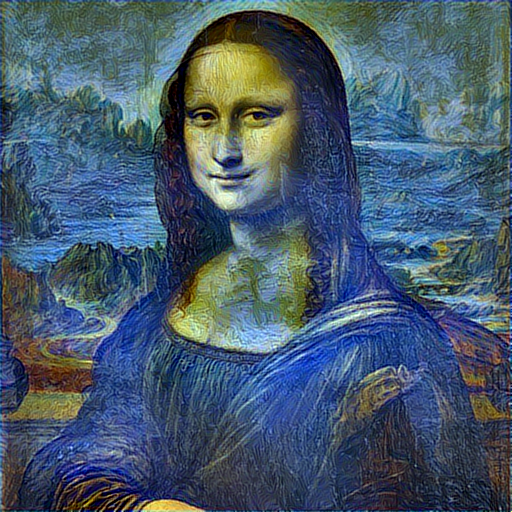

In [20]:
x = x.reshape((height, width, 3))
x = x[:, :, ::-1]
x[:, :, 0] += 103.939
x[:, :, 1] += 116.779
x[:, :, 2] += 123.68
x = np.clip(x, 0, 255).astype('uint8')

Image.fromarray(x)